In [1]:
import datetime as dt

import pandas as pd
from sklearn.preprocessing import (
    OneHotEncoder,
)
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from analytics.machine_learning.price_prediction_with_fundamentals import utils

In [2]:
dataset = utils.get_features(features_categories=['arctan_pct_change'], target='price_pct_change_next_three_months')

# Create categorical target
bins = [-float('inf'), -0.10, 0, 0.10, float('inf')]
label_mapping = {0: '-10-', 1: '-10 to 0', 2: '0 to 10', 3: '10+'}
labels = ['-10-', '-10 to 0', '0 to 10', '10+']

dataset['next_three_months_pct_change_range'] = pd.cut(
    dataset['price_pct_change_next_three_months'],
    bins=bins,
    labels=labels,
    right=False
)

In [9]:
dataset[['price_pct_change_next_three_months', 'next_three_months_pct_change_range']][:20]

,price_pct_change_next_three_months,next_three_months_pct_change_range
0,0.671429,5
1,-0.329293,0
2,0.175758,5
3,-0.020408,2
4,0.032765,3
5,0.055494,4
6,-0.033916,2
7,0.081433,4
8,0.100000,5
9,-0.054836,1


In [3]:
dataset['next_three_months_pct_change_range'].value_counts()

10+         15488
-10-        14334
0 to 10     11939
-10 to 0    11627
Name: next_three_months_pct_change_range, dtype: int64

# XGBoost

Overall Accuracy: 30.71%


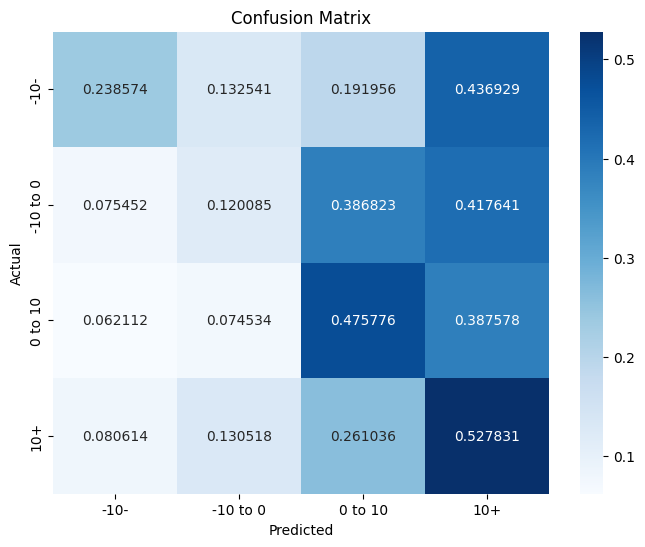

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np

dataset = utils.get_features(features_categories=['arctan_pct_change'], target='price_pct_change_next_three_months')

# Create categorical target
bins = [-float('inf'), -0.10, 0, 0.10, float('inf')]
label_mapping = {0: '-10-', 1: '-10 to 0', 2: '0 to 10', 3: '10+'}
labels = ['-10-', '-10 to 0', '0 to 10', '10+']

dataset['next_three_months_pct_change_range'] = pd.cut(
    dataset['price_pct_change_next_three_months'],
    bins=bins,
    labels=[0,1,2,3],
    right=False
)

# dataset['last_three_months_pct_change_range'] = pd.cut(
#     dataset['price_pct_change_three_months'],
#     bins=bins,
#     labels=labels,
#     right=False
# )

train_set, test_set = utils.split_data_to_train_and_test(
    df=dataset,
    cutoff_date=dt.datetime(2023,6,1)
)

cols_to_drop = ['symbol', 'fiscal_date_ending', 'price_pct_change_next_three_months', 'price_pct_change_three_months', 'next_three_months_pct_change_range']
target_col = 'next_three_months_pct_change_range'

y_train = train_set[target_col]
X_train = train_set.drop(cols_to_drop, axis=1)

y_test = test_set[target_col]
X_test = test_set.drop(cols_to_drop, axis=1)

# categorical_columns = ['sector', 'last_three_months_pct_change_range']
column_transformer = make_column_transformer(
    (
        OneHotEncoder(), ['sector']
    ),
    remainder='passthrough'
)

xgb_classifier = make_pipeline(
    column_transformer,
    xgb.XGBClassifier()
)

xgb_classifier.fit(X_train, y_train)
y_pred_xgb_classifier = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_xgb_classifier)
print(f"Overall Accuracy: {accuracy:.2%}")

y_test = [label_mapping[y] for y in y_test]
y_pred = [label_mapping[y] for y in y_pred_xgb_classifier]
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# KNN

Overall Accuracy: 28.35%


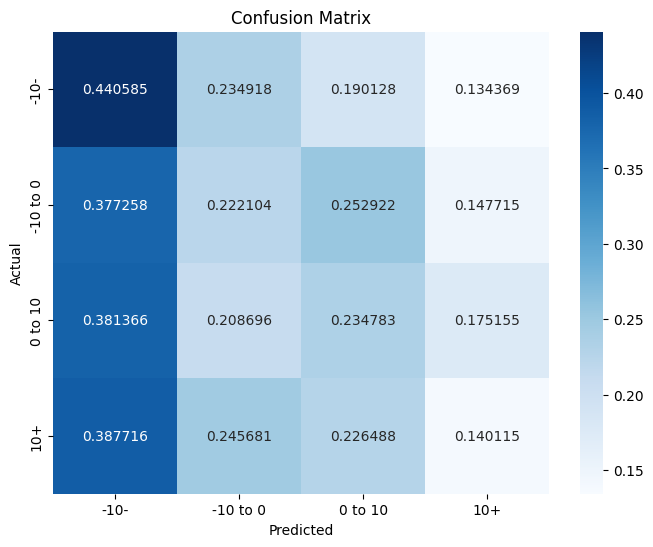

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

dataset = utils.get_features(features_categories=['arctan_pct_change'], target='price_pct_change_next_three_months')

# Create categorical target
bins = [-float('inf'), -0.10, 0, 0.10, float('inf')]
label_mapping = {0: '-10-', 1: '-10 to 0', 2: '0 to 10', 3: '10+'}
labels = ['-10-', '-10 to 0', '0 to 10', '10+']

dataset['next_three_months_pct_change_range'] = pd.cut(
    dataset['price_pct_change_next_three_months'],
    bins=bins,
    labels=labels,
    right=False
)

# dataset['last_three_months_pct_change_range'] = pd.cut(
#     dataset['price_pct_change_three_months'],
#     bins=bins,
#     labels=labels,
#     right=False
# )

train_set, test_set = utils.split_data_to_train_and_test(
    df=dataset,
    cutoff_date=dt.datetime(2023,6,1)
)

cols_to_drop = ['symbol', 'fiscal_date_ending', 'price_pct_change_next_three_months', 'price_pct_change_three_months', 'next_three_months_pct_change_range']
target_col = 'next_three_months_pct_change_range'

y_train = train_set[target_col]
X_train = train_set.drop(cols_to_drop, axis=1)

y_test = test_set[target_col]
X_test = test_set.drop(cols_to_drop, axis=1)

column_transformer = make_column_transformer(
    (
        OneHotEncoder(), ['sector',]
    ),
    remainder='passthrough'
)

knn_classifier = make_pipeline(
    column_transformer,
    KNeighborsClassifier(weights='uniform', n_neighbors=15)
)

knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_knn)
print(f"Overall Accuracy: {accuracy:.2%}")

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_knn, labels=labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Random Forrest

Overall Accuracy: 31.27%


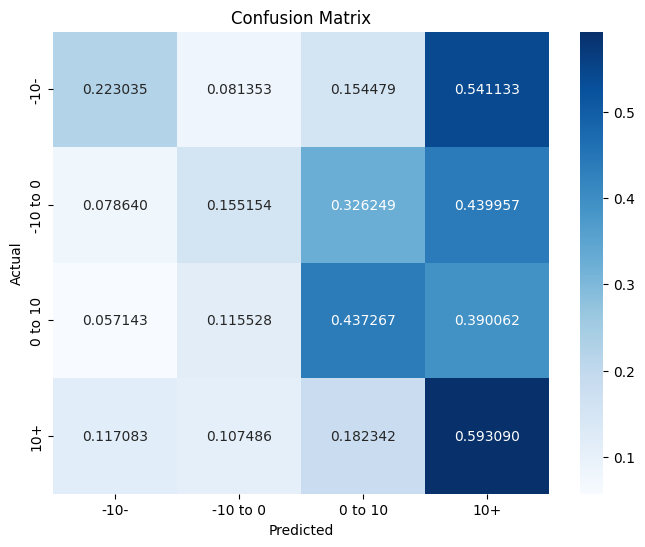

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

dataset = utils.get_features(features_categories=['arctan_pct_change'], target='price_pct_change_next_three_months')

bins = [-float('inf'), -0.10, 0, 0.10, float('inf')]
label_mapping = {0: '-10-', 1: '-10 to 0', 2: '0 to 10', 3: '10+'}
labels = ['-10-', '-10 to 0', '0 to 10', '10+']

dataset['next_three_months_pct_change_range'] = pd.cut(
    dataset['price_pct_change_next_three_months'],
    bins=bins,
    labels=labels,
    right=False
)

# dataset['last_three_months_pct_change_range'] = pd.cut(
#     dataset['price_pct_change_three_months'],
#     bins=bins,
#     labels=labels,
#     right=False
# )

train_set, test_set = utils.split_data_to_train_and_test(
    df=dataset,
    cutoff_date=dt.datetime(2023,6,1)
)

cols_to_drop = ['symbol', 'fiscal_date_ending', 'price_pct_change_next_three_months', 'price_pct_change_three_months', 'next_three_months_pct_change_range']
target_col = 'next_three_months_pct_change_range'

y_train = train_set[target_col]
X_train = train_set.drop(cols_to_drop, axis=1)

y_test = test_set[target_col]
X_test = test_set.drop(cols_to_drop, axis=1)

column_transformer = make_column_transformer(
    (
        OneHotEncoder(), ['sector']
    ),
    remainder='passthrough'
)

random_forrest_classifier = RandomForestClassifier(n_estimators=100)
random_forrest = make_pipeline(
    column_transformer,
    random_forrest_classifier
)

random_forrest.fit(X_train, y_train)
y_pred_random_forrest = random_forrest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_random_forrest)
print(f"Overall Accuracy: {accuracy:.2%}")

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_random_forrest, labels=labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# HistGradientBoostingClassifier

Overall Accuracy: 30.02%


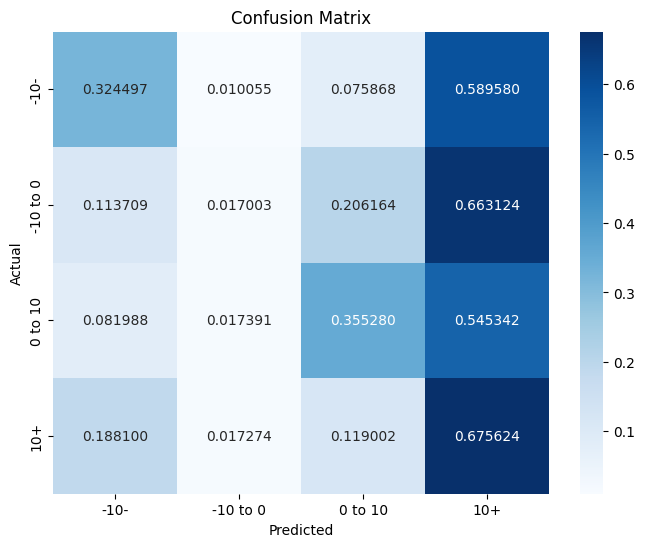

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingClassifier

dataset = utils.get_features(features_categories=['arctan_pct_change'], target='price_pct_change_next_three_months')

bins = [-float('inf'), -0.10, 0, 0.10, float('inf')]
label_mapping = {0: '-10-', 1: '-10 to 0', 2: '0 to 10', 3: '10+'}
labels = ['-10-', '-10 to 0', '0 to 10', '10+']

dataset['next_three_months_pct_change_range'] = pd.cut(
    dataset['price_pct_change_next_three_months'],
    bins=bins,
    labels=labels,
    right=False
)

# dataset['last_three_months_pct_change_range'] = pd.cut(
#     dataset['price_pct_change_three_months'],
#     bins=bins,
#     labels=labels,
#     right=False
# )

train_set, test_set = utils.split_data_to_train_and_test(
    df=dataset,
    cutoff_date=dt.datetime(2023,6,1)
)

cols_to_drop = ['symbol', 'fiscal_date_ending', 'price_pct_change_next_three_months', 'price_pct_change_three_months', 'next_three_months_pct_change_range']
target_col = 'next_three_months_pct_change_range'

y_train = train_set[target_col]
X_train = train_set.drop(cols_to_drop, axis=1)

y_test = test_set[target_col]
X_test = test_set.drop(cols_to_drop, axis=1)

column_transformer = make_column_transformer(
    (
        OneHotEncoder(), ['sector']
    ),
    remainder='passthrough'
)

hgbc = make_pipeline(
    column_transformer,
    HistGradientBoostingClassifier()
)

hgbc.fit(X_train, y_train)
y_pred_hgbc = hgbc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_hgbc)
print(f"Overall Accuracy: {accuracy:.2%}")

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_hgbc, labels=labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# XGB with custom metric function

[0]	validation_0-merror:77349.00000
[1]	validation_0-merror:75926.00000
[2]	validation_0-merror:76578.00000
[3]	validation_0-merror:76248.00000
[4]	validation_0-merror:75714.00000
[5]	validation_0-merror:75206.00000
[6]	validation_0-merror:74406.00000
[7]	validation_0-merror:73617.00000
[8]	validation_0-merror:73317.00000
[9]	validation_0-merror:72751.00000
[10]	validation_0-merror:72199.00000
[11]	validation_0-merror:71557.00000
[12]	validation_0-merror:70659.00000
[13]	validation_0-merror:70104.00000
[14]	validation_0-merror:69613.00000
[15]	validation_0-merror:69323.00000
[16]	validation_0-merror:68663.00000
[17]	validation_0-merror:68032.00000
[18]	validation_0-merror:67410.00000
[19]	validation_0-merror:67009.00000
[20]	validation_0-merror:66503.00000
[21]	validation_0-merror:66093.00000
[22]	validation_0-merror:65403.00000
[23]	validation_0-merror:64982.00000
[24]	validation_0-merror:64548.00000
[25]	validation_0-merror:64244.00000
[26]	validation_0-merror:63879.00000
[27]	valida

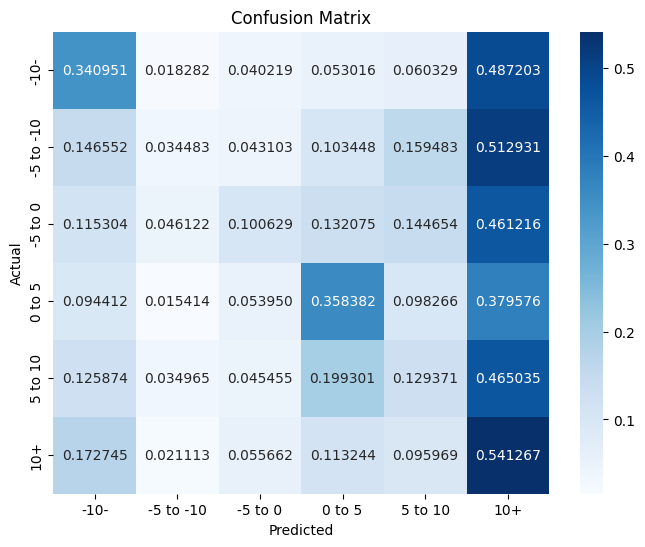

In [12]:
from typing import Tuple

import numpy as np
from scipy.special import softmax
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

dataset = utils.get_features(features_categories=['arctan_pct_change'], target='price_pct_change_next_three_months')

# Create categorical target
bins = [-float('inf'), -0.10, -0.05, 0, 0.05, 0.10, float('inf')]
labels = ['-10-', '-5 to -10', '-5 to 0', '0 to 5', '5 to 10', '10+']
label_mapping = {0: '-10-', 1: '-5 to -10', 2: '-5 to 0', 3: '0 to 5', 4: '5 to 10', 5: '10+'}

dataset['next_three_months_pct_change_range'] = pd.cut(
    dataset['price_pct_change_next_three_months'],
    bins=bins,
    labels=[0, 1, 2, 3, 4, 5],
    right=False
)

dataset['last_three_months_pct_change_range'] = pd.cut(
    dataset['price_pct_change_three_months'],
    bins=bins,
    labels=labels,
    right=False
)

train_set, test_set = utils.split_data_to_train_and_test(
    df=dataset,
    cutoff_date=dt.datetime(2023,6,1)
)

cols_to_drop = ['symbol', 'fiscal_date_ending', 'price_pct_change_next_three_months', 'price_pct_change_three_months', 'next_three_months_pct_change_range']
target_col = 'next_three_months_pct_change_range'
categorical_columns = ['sector', 'last_three_months_pct_change_range']

y_train = train_set[target_col]
X_train = train_set.drop(cols_to_drop, axis=1)

y_test = test_set[target_col]
X_test = test_set.drop(cols_to_drop, axis=1)

column_transformer = make_column_transformer(
    (
        OneHotEncoder(), categorical_columns
    ),
    remainder='passthrough'
)

def merror(labels: np.ndarray, predt: np.ndarray):
    predicted_labels = np.array([np.argmax(prediction) for prediction in predt])
    custom_error = 0
    for i in range(len(predicted_labels)):
        custom_error += abs(labels[i] - predicted_labels[i])
    
    return custom_error
    # cost_matrix = np.array([
    #     [0, 1, 2, 3, 4, 5],  # Costs for misclassifying '-10-' as other classes
    #     [1, 0, 1, 2, 3, 4],  # Costs for misclassifying '-5 to -10' as other classes
    #     [2, 1, 0, 1, 3, 4],  # Costs for misclassifying '-5 to 0' as other classes
    #     [4, 3, 2, 0, 1, 2],  # Costs for misclassifying '0 to 5' as other classes
    #     [4, 3, 2, 1, 0, 1],  # Costs for misclassifying '5 to 10' as other classes
    #     [5, 4, 3, 2, 1, 0]   # Costs for misclassifying '10+' as other classes
    # ])

    # for r in range(predt.shape[0]):
    #     target = labels[r]
    #     p = softmax(predt[r, :])
        
    #     for c in range(classes):
    #         g = p[c] - int(c == target)
    #         h = max((2.0 * p[c] * (1.0 - p[c])).item(), eps)            
    #         # Apply misclassification cost
    #         grad[r, c] = g * cost_matrix[target, c]
    #         hess[r, c] = h * cost_matrix[target, c]

    # grad = grad.reshape((rows * classes, 1))
    # hess = hess.reshape((rows * classes, 1))
    
    # return grad, hess

X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

# xgb_classifier = make_pipeline(
#     column_transformer,
#     xgb.XGBClassifier(tree_method="hist",eval_metric=merror)
# )

xgb_classifier = xgb.XGBClassifier(tree_method="hist",eval_metric=merror, disable_default_eval_metric=True, n_estimators=1000)
xgb_classifier.fit(X_train_transformed, y_train, eval_set=[(X_train_transformed, y_train)])
y_pred_xgb_classifier = xgb_classifier.predict(X_test_transformed)

y_test = [label_mapping[y] for y in y_test]
y_pred = [label_mapping[y] for y in y_pred_xgb_classifier]

accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.2%}")

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
